In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
!mkdir ./data
!curl https://www.stockphotosecrets.com/wp-content/uploads/2018/08/hide-the-pain-stockphoto-840x560.jpg >> ./data/stock.jpg

mkdir: cannot create directory ‘./data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28131  100 28131    0     0   231k      0 --:--:-- --:--:-- --:--:--  232k


In [3]:
!curl https://libreshot.com/wp-content/uploads/2019/10/old-wood-structure-861x574.jpg >> ./data/stock4.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  186k  100  186k    0     0   625k      0 --:--:-- --:--:-- --:--:--  625k


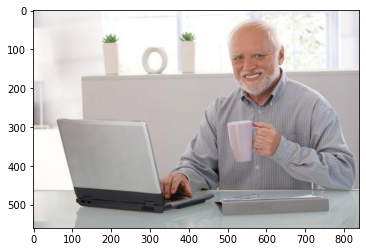

(3, 560, 840)

In [4]:
IM = plt.imread("./data/stock.jpg") / 255.
plt.imshow(IM)
plt.show()
IM = IM.transpose(2,0,1)
IM.shape

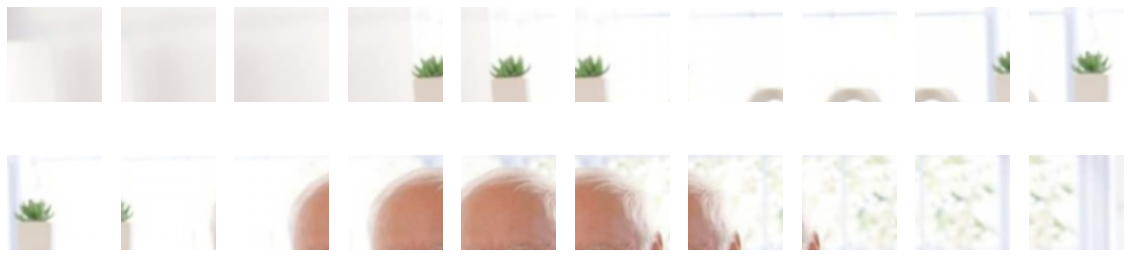

In [5]:
from Crop import *


IM_batch = np.asarray([IM for i in range(20)])
std_y = np.ones(20) * 1
std_x = np.ones(20) * 1
dx = np.ones(20) * 1
dy = np.ones(20) * 1
mean_x = np.linspace(0, 700,20)
mean_y = np.ones(20) * 10 #np.linspace(0,500,20)
params = np.stack([mean_y, std_y, dy, mean_x, std_x, dx ]).T

glimpse = gaussian_glimpse(IM_batch, params, (100, 100))

plt.rcParams["figure.figsize"] = (20, 5)
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.clip(glimpse[i].transpose(1,2,0), 0, 1))
    plt.axis("off")

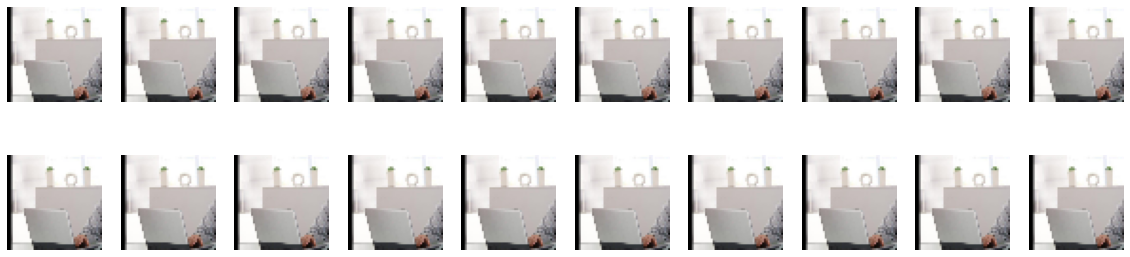

In [6]:
import torch.nn.functional as F
import torch.nn as nn

class ST(nn.Module):
    
    def __init__(self, ):
        super().__init__()
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(160, 32), 
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        

    def stn(self, x, uy=0, ux=0, trgt_size=(1,3,32, 32)):
        #xs = self.localization(x)
        #xs = xs.view(len(x), -1)
        #theta = self.fc_loc(xs)
        #theta = theta.view(-1, 2, 3)
        
        theta = torch.FloatTensor([[1,0,ux],[0,1,uy]]).view(1, 2, 3)
        grid = F.affine_grid(theta, trgt_size, align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x
    
    def forward(self, X):
        # transform the input
        x = self.stn(X, trgt_size=X.shape)
        return x

stn = ST().stn

for i in range(20):
    plt.subplot(2, 10, i+1)
    #out = stn(torch.FloatTensor(IM).unsqueeze(0)[:, :, :32, :32], ux=i/10).detach().numpy()
    
    out = stn(torch.FloatTensor(IM).unsqueeze(0)[:, :, :500, :500], ux=-0.1, uy=0, trgt_size=(1,3,50, 50)).detach().numpy()
    plt.imshow(out[0].transpose(1,2,0))
    plt.axis("off")

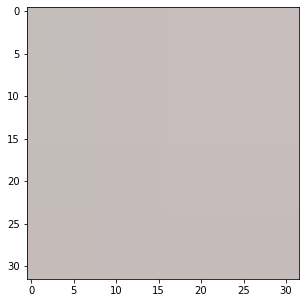

In [7]:
out = torch.FloatTensor(IM).unsqueeze(0)[:, :, 200:232, 200:232].numpy()
plt.imshow(out[0].transpose(1,2,0))

In [8]:
IM = torch.arange(121).view(1,1,11,11).float()
IM

tensor([[[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
          [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.],
          [ 22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.],
          [ 33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.],
          [ 44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.],
          [ 55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.],
          [ 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.],
          [ 77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.],
          [ 88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
          [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.],
          [110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.]]]])

In [9]:
x, y = -0, -0
theta = torch.FloatTensor([[1,0, x],[0,1, y]]).view(1, 2, 3)
grid = F.affine_grid(theta, (1 ,1, 1, 1), align_corners=False)
F.grid_sample(IM, grid, align_corners=False)

tensor([[[[60.]]]])

In [62]:
x, y = -0, -0
theta = torch.FloatTensor([[1,0, x],[0,1, y]]).view(1, 2, 3)
grid = F.affine_grid(theta, (1 ,1, 3, 3), align_corners=False)
F.grid_sample(IM, grid, align_corners=False)

ValueError: Expected a batch of 2D affine matrices of shape Nx2x3 for size (1, 1, 4, 4). Got torch.Size([1, 2]).

In [15]:
std_y = np.ones(1) * 1
std_x = np.ones(1) * 1
dx = np.ones(1) * 1
dy = np.ones(1) * 1
mean_x = np.ones(1) * 5
mean_y = np.ones(1) * 5
params = torch.from_numpy(np.stack([mean_y, std_y, dy, mean_x, std_x, dx ]).T).float()

glimpse = gaussian_glimpse(torch.cat([IM, IM]), torch.cat([params, params]), (3, 3))
glimpse

tensor([[[[60.0000, 61.0000, 61.9995],
          [70.9999, 71.9999, 72.9994],
          [81.9940, 82.9940, 83.9935]]],


        [[[60.0000, 61.0000, 61.9995],
          [70.9999, 71.9999, 72.9994],
          [81.9940, 82.9940, 83.9935]]]])

In [17]:
crop(torch.cat([IM, IM]), torch.Tensor([[3, 3], [5, 5]]), center=True)

tensor([[[[18.5739, 19.5292, 20.5262],
          [29.0823, 30.0376, 31.0345],
          [40.0486, 41.0039, 42.0009]]],


        [[[42.0009, 43.0008, 44.0008],
          [53.0001, 54.0000, 55.0000],
          [64.0001, 65.0000, 66.0000]]]])

In [13]:
class Model(nn.Module):
    
    
    def __init__(self, model):
        super().__init__()
        
        self.st = ST()
        self.model = model     
        
    def forward(self, X):
        X = X.view(-1, 3, 32, 32)
        X = self.st(X)
        X = X.view(len(X), -1)
        #X = model.transform(X)
        return X

mdl = Model(None)
for name, param in mdl.named_parameters():
    print(name)

st.localization.0.weight
st.localization.0.bias
st.localization.3.weight
st.localization.3.bias
st.fc_loc.0.weight
st.fc_loc.0.bias
st.fc_loc.2.weight
st.fc_loc.2.bias
